## 1. Import Libraries

In [3]:
# !pip install pandas numpy seaborn matplotlib scikit-learn lightgbm optuna

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import zipfile
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

warnings.filterwarnings('ignore')

## 2. Extract datasets

In [4]:
with zipfile.ZipFile("loan-approval-quantitativedata.zip", "r") as zip_ref:
    zip_ref.extractall("loan_data")

## 3. Load datasets

In [5]:
train_df = pd.read_csv('loan_data/train.csv')
test_df = pd.read_csv('loan_data/test.csv')

## 4. Clean column names

In [6]:
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

print("Columns in train_df:", train_df.columns.tolist())
print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)

Columns in train_df: ['id', 'person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length', 'loan_status']
Train Shape: (58645, 13)
Test Shape: (39098, 12)


## 5. Check and visualize missing values

In [7]:
print("\nMissing values in training set:")
print(train_df.isnull().sum())

target_col = 'loan_status'


Missing values in training set:
id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64


## 6. Encode target if it's Y/N

In [8]:
if train_df[target_col].dtype == 'object':
    train_df[target_col] = train_df[target_col].map({'Y': 1, 'N': 0})

## 7. Fill missing numerical values with median

In [9]:
for col in train_df.select_dtypes(include=np.number).columns:
    train_df[col].fillna(train_df[col].median(), inplace=True)
    if col in test_df.columns:
        test_df[col].fillna(test_df[col].median(), inplace=True)

## 8. Fill missing categorical values with mode

In [10]:
for col in train_df.select_dtypes(include='object').columns:
    train_df[col].fillna(train_df[col].mode()[0], inplace=True)
    if col in test_df.columns:
        test_df[col].fillna(train_df[col].mode()[0], inplace=True)

## 9. Correlation Heatmap

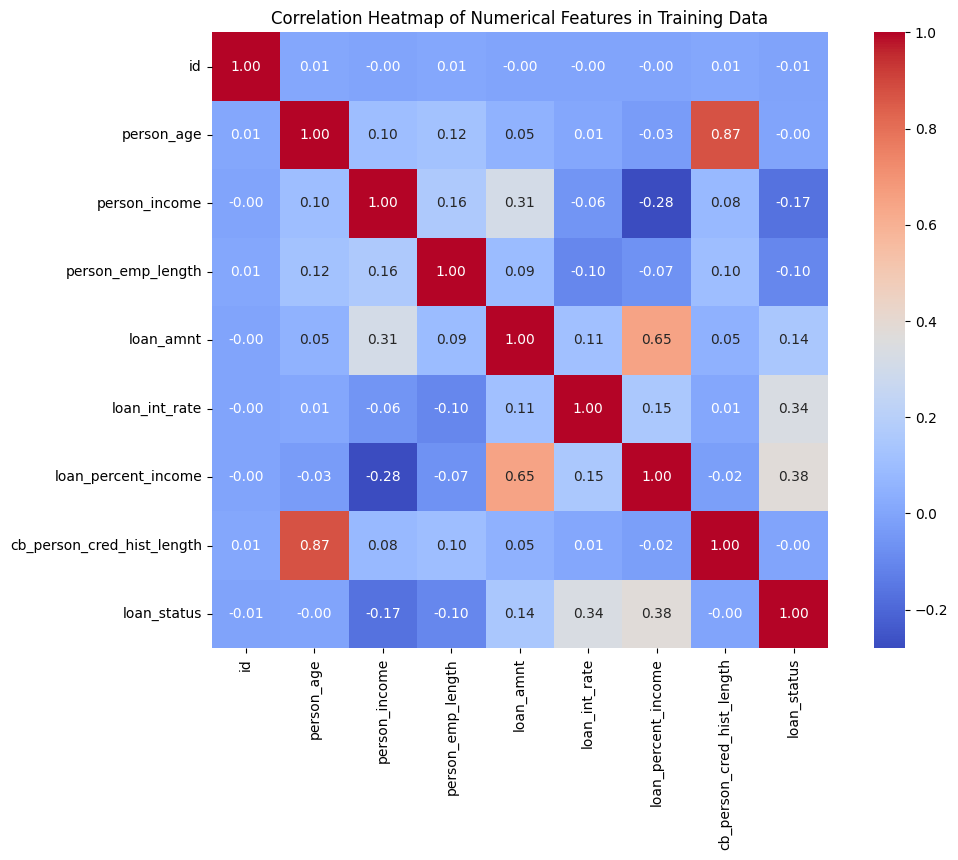

In [11]:
corr_matrix = train_df.select_dtypes(include=np.number).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title("Correlation Heatmap of Numerical Features in Training Data")
plt.show()

## 10. One-hot encoding for categorical features

In [12]:
X_train_all = pd.get_dummies(train_df.drop(target_col, axis=1))
X_test_all = pd.get_dummies(test_df)

## 11. Align columns of train and test sets after encoding

In [13]:
X_train_all, X_test_all = X_train_all.align(X_test_all, join='left', axis=1, fill_value=0)

y = train_df[target_col]

## 12. Train-validation split

In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y, test_size=0.2, random_state=42, stratify=y
)

## 13. Optuna objective function

In [15]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'is_unbalance': True,
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    }

    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    model = lgb.train(
        param,
        dtrain,
        valid_sets=[dval],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(0)]
    )

    preds = model.predict(X_val)
    auc = roc_auc_score(y_val, preds)
    return auc

## 14. Run Optuna study to find best hyperparameters

In [16]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("\nBest trial:")
trial = study.best_trial
print(f"  AUC: {trial.value}")
print("  Best params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'is_unbalance': True,
})

[I 2025-06-08 08:14:51,514] A new study created in memory with name: no-name-df780a6e-4ec4-40ac-927d-5359882bec49


Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:14:52,971] Trial 0 finished with value: 0.9492866637735564 and parameters: {'num_leaves': 33, 'max_depth': 5, 'learning_rate': 0.07548808601271102, 'feature_fraction': 0.9647379968498837, 'bagging_fraction': 0.7290540107776491, 'bagging_freq': 8, 'min_child_samples': 14, 'lambda_l1': 1.8240629747069286e-06, 'lambda_l2': 0.7383119143338527}. Best is trial 0 with value: 0.9492866637735564.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.949287
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:14:53,501] Trial 1 finished with value: 0.9168458787762978 and parameters: {'num_leaves': 125, 'max_depth': 3, 'learning_rate': 0.008815740978706623, 'feature_fraction': 0.8931765983059861, 'bagging_fraction': 0.6651307328948014, 'bagging_freq': 1, 'min_child_samples': 9, 'lambda_l1': 3.795402625793847e-06, 'lambda_l2': 0.03473634345982244}. Best is trial 0 with value: 0.9492866637735564.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.916846
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:14:54,892] Trial 2 finished with value: 0.9475329984230765 and parameters: {'num_leaves': 103, 'max_depth': 11, 'learning_rate': 0.020787628992622206, 'feature_fraction': 0.8775259347229454, 'bagging_fraction': 0.9818582494531989, 'bagging_freq': 2, 'min_child_samples': 12, 'lambda_l1': 0.00612162739883393, 'lambda_l2': 1.8515168906576132e-05}. Best is trial 0 with value: 0.9492866637735564.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.947533
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:14:56,269] Trial 3 finished with value: 0.9417045717690774 and parameters: {'num_leaves': 86, 'max_depth': 9, 'learning_rate': 0.0084018690176398, 'feature_fraction': 0.826307207466635, 'bagging_fraction': 0.7542426334028078, 'bagging_freq': 1, 'min_child_samples': 28, 'lambda_l1': 0.06768145804492845, 'lambda_l2': 0.09029738895775707}. Best is trial 0 with value: 0.9492866637735564.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.941705
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:14:56,979] Trial 4 finished with value: 0.9251554749135787 and parameters: {'num_leaves': 128, 'max_depth': 4, 'learning_rate': 0.010460251491390649, 'feature_fraction': 0.6079764550615376, 'bagging_fraction': 0.9647879127698533, 'bagging_freq': 7, 'min_child_samples': 64, 'lambda_l1': 0.09349203740676698, 'lambda_l2': 0.0023741668505148175}. Best is trial 0 with value: 0.9492866637735564.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.925155
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:14:58,179] Trial 5 finished with value: 0.9398715542371863 and parameters: {'num_leaves': 93, 'max_depth': 9, 'learning_rate': 0.005845541582551386, 'feature_fraction': 0.8619202433973754, 'bagging_fraction': 0.876816654880638, 'bagging_freq': 4, 'min_child_samples': 11, 'lambda_l1': 0.03797755136260048, 'lambda_l2': 0.7733954946584471}. Best is trial 0 with value: 0.9492866637735564.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.939872
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:14:59,072] Trial 6 finished with value: 0.9317716490669123 and parameters: {'num_leaves': 77, 'max_depth': 6, 'learning_rate': 0.005209560456602134, 'feature_fraction': 0.8507747252077822, 'bagging_fraction': 0.7875364814367792, 'bagging_freq': 4, 'min_child_samples': 79, 'lambda_l1': 3.452304032648482e-07, 'lambda_l2': 5.798532671976918e-06}. Best is trial 0 with value: 0.9492866637735564.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.931772
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:14:59,978] Trial 7 finished with value: 0.94297721288708 and parameters: {'num_leaves': 51, 'max_depth': 7, 'learning_rate': 0.023274881439181654, 'feature_fraction': 0.8784370148362711, 'bagging_fraction': 0.7053252024851744, 'bagging_freq': 8, 'min_child_samples': 79, 'lambda_l1': 8.590867458448837e-05, 'lambda_l2': 1.0416640063391586e-05}. Best is trial 0 with value: 0.9492866637735564.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.942977
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:00,780] Trial 8 finished with value: 0.9341562327179819 and parameters: {'num_leaves': 38, 'max_depth': 5, 'learning_rate': 0.021219329964090854, 'feature_fraction': 0.8680324065677703, 'bagging_fraction': 0.9186604374657191, 'bagging_freq': 2, 'min_child_samples': 72, 'lambda_l1': 0.5370008077669076, 'lambda_l2': 1.4628660208251478e-08}. Best is trial 0 with value: 0.9492866637735564.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.934156
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:01,696] Trial 9 finished with value: 0.9392451303774795 and parameters: {'num_leaves': 70, 'max_depth': 6, 'learning_rate': 0.018781957035948208, 'feature_fraction': 0.6578656624184451, 'bagging_fraction': 0.9236107370322545, 'bagging_freq': 4, 'min_child_samples': 70, 'lambda_l1': 0.0008566980521135091, 'lambda_l2': 8.589960971661832e-06}. Best is trial 0 with value: 0.9492866637735564.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.939245
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:02,947] Trial 10 finished with value: 0.9543187409850743 and parameters: {'num_leaves': 26, 'max_depth': 12, 'learning_rate': 0.08574912286458833, 'feature_fraction': 0.9561199819112683, 'bagging_fraction': 0.6422507277916583, 'bagging_freq': 10, 'min_child_samples': 40, 'lambda_l1': 3.411321143372662e-08, 'lambda_l2': 5.474220750268141}. Best is trial 10 with value: 0.9543187409850743.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.954319
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:05,140] Trial 11 finished with value: 0.9536689222211706 and parameters: {'num_leaves': 23, 'max_depth': 12, 'learning_rate': 0.08948694923277556, 'feature_fraction': 0.9987666416918912, 'bagging_fraction': 0.6133462470001061, 'bagging_freq': 10, 'min_child_samples': 38, 'lambda_l1': 1.173808611341625e-07, 'lambda_l2': 4.953542468649762}. Best is trial 10 with value: 0.9543187409850743.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.953669
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:06,277] Trial 12 finished with value: 0.9548768552962671 and parameters: {'num_leaves': 22, 'max_depth': 12, 'learning_rate': 0.099655025868485, 'feature_fraction': 0.9765623406015672, 'bagging_fraction': 0.6033284139634604, 'bagging_freq': 10, 'min_child_samples': 43, 'lambda_l1': 1.1195948277583524e-08, 'lambda_l2': 7.4101271095541525}. Best is trial 12 with value: 0.9548768552962671.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.954877
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:07,289] Trial 13 finished with value: 0.9518162005842177 and parameters: {'num_leaves': 54, 'max_depth': 10, 'learning_rate': 0.051647935857578785, 'feature_fraction': 0.747098633354492, 'bagging_fraction': 0.60217075365914, 'bagging_freq': 10, 'min_child_samples': 99, 'lambda_l1': 1.0449311397078117e-08, 'lambda_l2': 6.083963355977818}. Best is trial 12 with value: 0.9548768552962671.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.951816
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:08,349] Trial 14 finished with value: 0.949375629891425 and parameters: {'num_leaves': 53, 'max_depth': 12, 'learning_rate': 0.04653266739159931, 'feature_fraction': 0.9383756166724507, 'bagging_fraction': 0.6622116048027494, 'bagging_freq': 9, 'min_child_samples': 47, 'lambda_l1': 1.1797736257311774e-08, 'lambda_l2': 0.007769414064551073}. Best is trial 12 with value: 0.9548768552962671.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.949376
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:09,285] Trial 15 finished with value: 0.9523076721594094 and parameters: {'num_leaves': 28, 'max_depth': 10, 'learning_rate': 0.05657827999773977, 'feature_fraction': 0.7661627432859531, 'bagging_fraction': 0.6582459216617295, 'bagging_freq': 6, 'min_child_samples': 30, 'lambda_l1': 3.242121083726844e-05, 'lambda_l2': 0.0005261096890856846}. Best is trial 12 with value: 0.9548768552962671.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.952308
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:10,350] Trial 16 finished with value: 0.9499700271392796 and parameters: {'num_leaves': 44, 'max_depth': 12, 'learning_rate': 0.0358903844548696, 'feature_fraction': 0.9386580533452015, 'bagging_fraction': 0.8398948673226695, 'bagging_freq': 9, 'min_child_samples': 53, 'lambda_l1': 5.3315173444346575, 'lambda_l2': 0.26381943817075215}. Best is trial 12 with value: 0.9548768552962671.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.94997
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:11,385] Trial 17 finished with value: 0.9536120720086817 and parameters: {'num_leaves': 66, 'max_depth': 9, 'learning_rate': 0.09687050368847462, 'feature_fraction': 0.9862168080897524, 'bagging_fraction': 0.6351011387328502, 'bagging_freq': 10, 'min_child_samples': 51, 'lambda_l1': 1.1458007825573173e-07, 'lambda_l2': 2.0846594426547883e-08}. Best is trial 12 with value: 0.9548768552962671.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.953612
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:12,664] Trial 18 finished with value: 0.9480560501424827 and parameters: {'num_leaves': 146, 'max_depth': 11, 'learning_rate': 0.035729264962793064, 'feature_fraction': 0.9231989285499457, 'bagging_fraction': 0.7059205922677375, 'bagging_freq': 6, 'min_child_samples': 26, 'lambda_l1': 5.62605584193467e-06, 'lambda_l2': 7.5424396311235995}. Best is trial 12 with value: 0.9548768552962671.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.948056
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:13,535] Trial 19 finished with value: 0.9536679399923683 and parameters: {'num_leaves': 21, 'max_depth': 8, 'learning_rate': 0.06664661972863545, 'feature_fraction': 0.7937819470497619, 'bagging_fraction': 0.7934487854945468, 'bagging_freq': 8, 'min_child_samples': 39, 'lambda_l1': 3.810678612152905e-07, 'lambda_l2': 0.03393129936983994}. Best is trial 12 with value: 0.9548768552962671.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.953668
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:14,661] Trial 20 finished with value: 0.9495156421424971 and parameters: {'num_leaves': 63, 'max_depth': 11, 'learning_rate': 0.04092190220094675, 'feature_fraction': 0.9183366270417735, 'bagging_fraction': 0.6854414700668094, 'bagging_freq': 9, 'min_child_samples': 61, 'lambda_l1': 4.2379846497142335e-08, 'lambda_l2': 0.9837373545316096}. Best is trial 12 with value: 0.9548768552962671.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.949516
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:16,880] Trial 21 finished with value: 0.955382345955271 and parameters: {'num_leaves': 22, 'max_depth': 12, 'learning_rate': 0.09855200503164138, 'feature_fraction': 0.9946268549864894, 'bagging_fraction': 0.6012301515576955, 'bagging_freq': 10, 'min_child_samples': 40, 'lambda_l1': 6.04512223662702e-08, 'lambda_l2': 7.277663527205897}. Best is trial 21 with value: 0.955382345955271.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.955382
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:17,783] Trial 22 finished with value: 0.9552010800945083 and parameters: {'num_leaves': 38, 'max_depth': 12, 'learning_rate': 0.0992391840493411, 'feature_fraction': 0.9604824570498329, 'bagging_fraction': 0.6006493079629083, 'bagging_freq': 10, 'min_child_samples': 40, 'lambda_l1': 7.998862832867042e-07, 'lambda_l2': 2.0483839422662107}. Best is trial 21 with value: 0.955382345955271.


Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.955201
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:18,703] Trial 23 finished with value: 0.953381754236829 and parameters: {'num_leaves': 39, 'max_depth': 10, 'learning_rate': 0.06735205639565083, 'feature_fraction': 0.999708738694464, 'bagging_fraction': 0.6010613476409856, 'bagging_freq': 9, 'min_child_samples': 19, 'lambda_l1': 5.076972827181898e-07, 'lambda_l2': 0.19281350883498458}. Best is trial 21 with value: 0.955382345955271.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.953382
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:19,492] Trial 24 finished with value: 0.9512301671634363 and parameters: {'num_leaves': 20, 'max_depth': 11, 'learning_rate': 0.06297529706205021, 'feature_fraction': 0.9685631503358154, 'bagging_fraction': 0.6311366229998752, 'bagging_freq': 7, 'min_child_samples': 45, 'lambda_l1': 1.3533507748420937e-05, 'lambda_l2': 1.0134315435360735}. Best is trial 21 with value: 0.955382345955271.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.95123
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:20,399] Trial 25 finished with value: 0.9541330104479381 and parameters: {'num_leaves': 42, 'max_depth': 12, 'learning_rate': 0.09571160953580715, 'feature_fraction': 0.9033130103084637, 'bagging_fraction': 0.6849228787413795, 'bagging_freq': 10, 'min_child_samples': 33, 'lambda_l1': 8.828902604729404e-07, 'lambda_l2': 0.010247748859988403}. Best is trial 21 with value: 0.955382345955271.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.954133
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:21,338] Trial 26 finished with value: 0.9564720841645074 and parameters: {'num_leaves': 33, 'max_depth': 10, 'learning_rate': 0.07681222911953418, 'feature_fraction': 0.7090674878963321, 'bagging_fraction': 0.7594126495252507, 'bagging_freq': 7, 'min_child_samples': 55, 'lambda_l1': 0.00039727233912444765, 'lambda_l2': 5.619259145486464e-07}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.956472
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:22,408] Trial 27 finished with value: 0.9497516151710893 and parameters: {'num_leaves': 48, 'max_depth': 10, 'learning_rate': 0.028197371514006506, 'feature_fraction': 0.7019874344422938, 'bagging_fraction': 0.746162187208453, 'bagging_freq': 5, 'min_child_samples': 54, 'lambda_l1': 0.00046200917737843013, 'lambda_l2': 1.9374921300485194e-07}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.949752
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:23,362] Trial 28 finished with value: 0.9424935396132875 and parameters: {'num_leaves': 33, 'max_depth': 8, 'learning_rate': 0.015144114782525314, 'feature_fraction': 0.6997475709537105, 'bagging_fraction': 0.8341767514977012, 'bagging_freq': 7, 'min_child_samples': 22, 'lambda_l1': 0.003493627514916068, 'lambda_l2': 4.900806214096844e-07}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.942494
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:24,481] Trial 29 finished with value: 0.9546896067691637 and parameters: {'num_leaves': 61, 'max_depth': 11, 'learning_rate': 0.0760625885048049, 'feature_fraction': 0.7078819510850711, 'bagging_fraction': 0.7399931936979008, 'bagging_freq': 8, 'min_child_samples': 57, 'lambda_l1': 9.365381865952371e-05, 'lambda_l2': 4.6640546546798244e-05}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.95469
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:25,412] Trial 30 finished with value: 0.955571052943323 and parameters: {'num_leaves': 31, 'max_depth': 10, 'learning_rate': 0.07612954095647298, 'feature_fraction': 0.6202686863543689, 'bagging_fraction': 0.773799355260558, 'bagging_freq': 8, 'min_child_samples': 33, 'lambda_l1': 0.002713119221388639, 'lambda_l2': 0.0002194024290633941}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.955571
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:26,350] Trial 31 finished with value: 0.9560433561746177 and parameters: {'num_leaves': 33, 'max_depth': 10, 'learning_rate': 0.07576311663937658, 'feature_fraction': 0.6087652244070239, 'bagging_fraction': 0.768315412473195, 'bagging_freq': 8, 'min_child_samples': 35, 'lambda_l1': 0.0026101271687414217, 'lambda_l2': 0.00012573170758045266}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.956043
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:28,780] Trial 32 finished with value: 0.9556848128973191 and parameters: {'num_leaves': 33, 'max_depth': 9, 'learning_rate': 0.07703035838398181, 'feature_fraction': 0.6028313975859039, 'bagging_fraction': 0.7698915946915088, 'bagging_freq': 8, 'min_child_samples': 47, 'lambda_l1': 0.0025618456474715253, 'lambda_l2': 0.00016174629320377855}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.955685
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:29,711] Trial 33 finished with value: 0.9554609837884624 and parameters: {'num_leaves': 34, 'max_depth': 9, 'learning_rate': 0.07308480559255497, 'feature_fraction': 0.6006101026357532, 'bagging_fraction': 0.7676069493289374, 'bagging_freq': 8, 'min_child_samples': 34, 'lambda_l1': 0.002935871768415504, 'lambda_l2': 0.00014617149566965542}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.955461
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:30,645] Trial 34 finished with value: 0.9527504489976204 and parameters: {'num_leaves': 31, 'max_depth': 8, 'learning_rate': 0.05491301268562535, 'feature_fraction': 0.6380281233504884, 'bagging_fraction': 0.8222790073991699, 'bagging_freq': 7, 'min_child_samples': 49, 'lambda_l1': 0.010700401124546254, 'lambda_l2': 0.0004603943186723101}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.95275
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:31,688] Trial 35 finished with value: 0.9521299780397452 and parameters: {'num_leaves': 59, 'max_depth': 9, 'learning_rate': 0.045345515708666614, 'feature_fraction': 0.63892565455305, 'bagging_fraction': 0.7217578527137862, 'bagging_freq': 6, 'min_child_samples': 20, 'lambda_l1': 0.0011678176601957711, 'lambda_l2': 0.00010278612572714521}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.95213
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:32,893] Trial 36 finished with value: 0.9539851403664487 and parameters: {'num_leaves': 95, 'max_depth': 10, 'learning_rate': 0.0777496392820254, 'feature_fraction': 0.6708180044464838, 'bagging_fraction': 0.7738429590549262, 'bagging_freq': 7, 'min_child_samples': 60, 'lambda_l1': 0.00019140881554651648, 'lambda_l2': 9.56945713913154e-07}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.953985
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:33,834] Trial 37 finished with value: 0.9529326077936581 and parameters: {'num_leaves': 47, 'max_depth': 7, 'learning_rate': 0.059881336908181676, 'feature_fraction': 0.6275881810334825, 'bagging_fraction': 0.8146993363427624, 'bagging_freq': 5, 'min_child_samples': 7, 'lambda_l1': 0.01176689349592957, 'lambda_l2': 0.0016850035983645192}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.952933
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:35,070] Trial 38 finished with value: 0.9491127497465552 and parameters: {'num_leaves': 112, 'max_depth': 9, 'learning_rate': 0.0301228294377619, 'feature_fraction': 0.6721910359992345, 'bagging_fraction': 0.8588770077654235, 'bagging_freq': 8, 'min_child_samples': 15, 'lambda_l1': 0.18963037175059766, 'lambda_l2': 1.8220407323916899e-06}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.949113
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:36,222] Trial 39 finished with value: 0.9438299065453942 and parameters: {'num_leaves': 76, 'max_depth': 10, 'learning_rate': 0.012572419494711388, 'feature_fraction': 0.6169486640962047, 'bagging_fraction': 0.7692273074009248, 'bagging_freq': 7, 'min_child_samples': 68, 'lambda_l1': 0.03470866535612623, 'lambda_l2': 0.0015650019226563896}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.94383
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:36,805] Trial 40 finished with value: 0.9364248240768687 and parameters: {'num_leaves': 32, 'max_depth': 3, 'learning_rate': 0.07953659013651625, 'feature_fraction': 0.6574081644895343, 'bagging_fraction': 0.7961030427692315, 'bagging_freq': 8, 'min_child_samples': 34, 'lambda_l1': 0.002365422136477836, 'lambda_l2': 2.9570495017659235e-05}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.936425
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:37,744] Trial 41 finished with value: 0.9544992924976174 and parameters: {'num_leaves': 35, 'max_depth': 9, 'learning_rate': 0.07046496719815439, 'feature_fraction': 0.6015124328803686, 'bagging_fraction': 0.7609703972518025, 'bagging_freq': 8, 'min_child_samples': 34, 'lambda_l1': 0.00036729032295088065, 'lambda_l2': 0.00018795764293823883}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.954499
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:38,726] Trial 42 finished with value: 0.9531331610563544 and parameters: {'num_leaves': 44, 'max_depth': 9, 'learning_rate': 0.049855566899178694, 'feature_fraction': 0.6053661064548322, 'bagging_fraction': 0.7322994336274534, 'bagging_freq': 9, 'min_child_samples': 30, 'lambda_l1': 0.0017762974333251872, 'lambda_l2': 8.485301554560983e-05}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.953133
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:41,143] Trial 43 finished with value: 0.9544087488607633 and parameters: {'num_leaves': 28, 'max_depth': 8, 'learning_rate': 0.07332558968621793, 'feature_fraction': 0.6490410817527602, 'bagging_fraction': 0.7814062725954775, 'bagging_freq': 8, 'min_child_samples': 27, 'lambda_l1': 0.013601650950256788, 'lambda_l2': 1.7925870706323335e-05}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.954409
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:42,279] Trial 44 finished with value: 0.9547108586287014 and parameters: {'num_leaves': 54, 'max_depth': 10, 'learning_rate': 0.06103071350239862, 'feature_fraction': 0.6815020764016488, 'bagging_fraction': 0.8100528086072181, 'bagging_freq': 7, 'min_child_samples': 48, 'lambda_l1': 0.003640918117286068, 'lambda_l2': 2.2425232454989855e-06}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.954711
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:43,171] Trial 45 finished with value: 0.9547527670575938 and parameters: {'num_leaves': 35, 'max_depth': 7, 'learning_rate': 0.08510766102892518, 'feature_fraction': 0.6219142900696839, 'bagging_fraction': 0.7138233623727703, 'bagging_freq': 6, 'min_child_samples': 24, 'lambda_l1': 0.033345517893982296, 'lambda_l2': 0.00023361981314054002}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.954753
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:44,173] Trial 46 finished with value: 0.9524153303890279 and parameters: {'num_leaves': 28, 'max_depth': 11, 'learning_rate': 0.042528036631838885, 'feature_fraction': 0.7180364373992182, 'bagging_fraction': 0.7592465767419608, 'bagging_freq': 9, 'min_child_samples': 45, 'lambda_l1': 0.0008502839115246485, 'lambda_l2': 8.214073822276364e-08}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.952415
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:45,206] Trial 47 finished with value: 0.9369348091767553 and parameters: {'num_leaves': 39, 'max_depth': 8, 'learning_rate': 0.006307530073317205, 'feature_fraction': 0.7424945329834921, 'bagging_fraction': 0.8904347240708801, 'bagging_freq': 8, 'min_child_samples': 15, 'lambda_l1': 0.0001464250570274835, 'lambda_l2': 0.0007622518081953451}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.936935
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:46,260] Trial 48 finished with value: 0.9551474444490083 and parameters: {'num_leaves': 50, 'max_depth': 9, 'learning_rate': 0.08549533039472404, 'feature_fraction': 0.6252151414475009, 'bagging_fraction': 0.7822723491929375, 'bagging_freq': 7, 'min_child_samples': 34, 'lambda_l1': 5.5441987155853344e-05, 'lambda_l2': 1.0469145796869289e-05}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.955147
Training until validation scores don't improve for 50 rounds


[I 2025-06-08 08:15:47,217] Trial 49 finished with value: 0.9512093022425175 and parameters: {'num_leaves': 57, 'max_depth': 6, 'learning_rate': 0.05668843920469576, 'feature_fraction': 0.6011603877672174, 'bagging_fraction': 0.9991612127332731, 'bagging_freq': 3, 'min_child_samples': 85, 'lambda_l1': 0.1731954209383714, 'lambda_l2': 5.428081810806231e-06}. Best is trial 26 with value: 0.9564720841645074.


Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.951209

Best trial:
  AUC: 0.9564720841645074
  Best params:
    num_leaves: 33
    max_depth: 10
    learning_rate: 0.07681222911953418
    feature_fraction: 0.7090674878963321
    bagging_fraction: 0.7594126495252507
    bagging_freq: 7
    min_child_samples: 55
    lambda_l1: 0.00039727233912444765
    lambda_l2: 5.619259145486464e-07


## 15. Train final model on full training data

In [17]:
dtrain_full = lgb.Dataset(X_train_all, label=y)

final_model = lgb.train(
    best_params,
    dtrain_full,
    num_boost_round=1000,
    valid_sets=[dtrain_full],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(10)]
)

[10]	training's auc: 0.940162
[20]	training's auc: 0.947314
[30]	training's auc: 0.951851
[40]	training's auc: 0.956071
[50]	training's auc: 0.959563
[60]	training's auc: 0.961938
[70]	training's auc: 0.963792
[80]	training's auc: 0.96579
[90]	training's auc: 0.967876
[100]	training's auc: 0.969717
[110]	training's auc: 0.971215
[120]	training's auc: 0.972711
[130]	training's auc: 0.974064
[140]	training's auc: 0.975188
[150]	training's auc: 0.976237
[160]	training's auc: 0.977088
[170]	training's auc: 0.978073
[180]	training's auc: 0.978836
[190]	training's auc: 0.979517
[200]	training's auc: 0.980446
[210]	training's auc: 0.981178
[220]	training's auc: 0.981852
[230]	training's auc: 0.982519
[240]	training's auc: 0.983238
[250]	training's auc: 0.983876
[260]	training's auc: 0.984584
[270]	training's auc: 0.985259
[280]	training's auc: 0.98583
[290]	training's auc: 0.986289
[300]	training's auc: 0.986686
[310]	training's auc: 0.98711
[320]	training's auc: 0.987502
[330]	training's auc

## 16. Predict on test set probabilities

In [18]:
final_pred_prob = final_model.predict(X_test_all)

final_pred = (final_pred_prob >= 0.5).astype(int)

submission = pd.DataFrame({
    'id': test_df['id'],
    'loan_status': final_pred
})

## 17. Save submission file

In [19]:
submission.to_csv('submission.csv', index=False)
print("✅ Submission file saved as 'submission.csv'")

print(submission.dtypes)

✅ Submission file saved as 'submission.csv'
id             int64
loan_status    int64
dtype: object


## 18. Feature importance plot

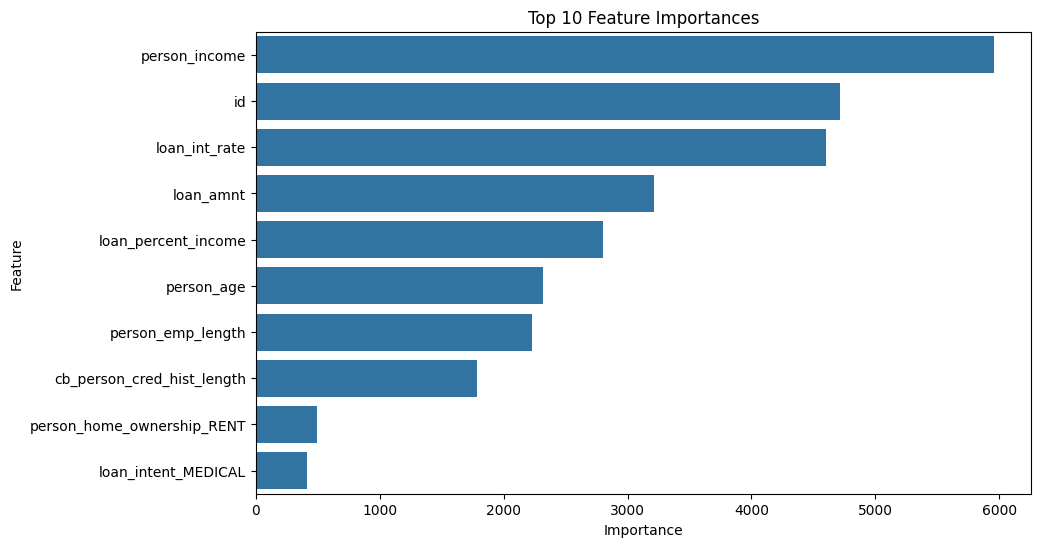

In [20]:
importances = pd.DataFrame({
    'Feature': X_train_all.columns,
    'Importance': final_model.feature_importance()
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances.head(10), x='Importance', y='Feature')
plt.title("Top 10 Feature Importances")
plt.show()